In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
filenames = [
              "./Reviews/ANUJA HOSPITAL/reviews.csv",
            ]

# merging two csv files
df = pd.concat(
    map(pd.read_csv, filenames), ignore_index=True)

print(len(df))
df

46


,Rating,Review
0,5 stars,This hospital is best which I've ever seen. Dr...
1,5 stars,Very good Hospital..very good facility and Ver...
2,5 stars,Dr. Rahul Birajdar is extremally talented doct...
3,5 stars,Dr Rahul Birajdar sir and The complete staff i...
4,5 stars,I have had a great experience with all my ailm...
5,5 stars,Thank you Dr. Suryakant and Dr.Rahul. Dr. Sury...
6,5 stars,Excellent hospital. Doctors are having in dept...
7,5 stars,Recently underwent covid treatment under Docto...
8,1 star,Treatment and medicine provided for kidney sto...
9,5 stars,Namrata mam is absolutely good.. She gives gen...


In [4]:
review_remove_translated = []

reviews_dict = df.to_dict('list')

for review in reviews_dict['Review']:
  review_sep = str(review).split("(Translated by Google) ")
  
  # Jika terdapat (Translated by Google)
  if review_sep[0] == "":
    review_sep = ("".join(review_sep)).split("(Original)")
    review_sep = review_sep[0]
    review = "".join(review_sep)
  
  review_remove_translated.append(review)

In [5]:
reviews_dict['Review'] = review_remove_translated
df = pd.DataFrame(reviews_dict)
df

,Rating,Review
0,5 stars,This hospital is best which I've ever seen. Dr...
1,5 stars,Very good Hospital..very good facility and Ver...
2,5 stars,Dr. Rahul Birajdar is extremally talented doct...
3,5 stars,Dr Rahul Birajdar sir and The complete staff i...
4,5 stars,I have had a great experience with all my ailm...
5,5 stars,Thank you Dr. Suryakant and Dr.Rahul. Dr. Sury...
6,5 stars,Excellent hospital. Doctors are having in dept...
7,5 stars,Recently underwent covid treatment under Docto...
8,1 star,Treatment and medicine provided for kidney sto...
9,5 stars,Namrata mam is absolutely good.. She gives gen...


In [6]:
import string
import re

In [7]:
def clean_review(review):
    return re.sub('[^a-zA-Z]', ' ', review).lower()
  
df['cleaned_review'] = df['Review'].apply(lambda x: clean_review(str(x)))
df['label'] = df['Rating'].map({"1 star":0, "2 stars":0, "3 stars":0, "4 stars":1, "5 stars":1})

In [8]:
def count_punct(review):
    count = sum([1 for char in review if char in string.punctuation])
    return round(count/(len(review) - review.count(" ")), 3)*100
  
df['review_len'] = df['Review'].apply(lambda x: len(str(x)) - str(x).count(" "))
df['punct'] = df['Review'].apply(lambda x: count_punct(str(x)))
df

,Rating,Review,cleaned_review,label,review_len,punct
0,5 stars,This hospital is best which I've ever seen. Dr...,this hospital is best which i ve ever seen dr...,1,571,4.0
1,5 stars,Very good Hospital..very good facility and Ver...,very good hospital very good facility and ver...,1,271,4.8
2,5 stars,Dr. Rahul Birajdar is extremally talented doct...,dr rahul birajdar is extremally talented doct...,1,217,3.2
3,5 stars,Dr Rahul Birajdar sir and The complete staff i...,dr rahul birajdar sir and the complete staff i...,1,519,2.3
4,5 stars,I have had a great experience with all my ailm...,i have had a great experience with all my ailm...,1,190,4.7
5,5 stars,Thank you Dr. Suryakant and Dr.Rahul. Dr. Sury...,thank you dr suryakant and dr rahul dr sury...,1,237,4.2
6,5 stars,Excellent hospital. Doctors are having in dept...,excellent hospital doctors are having in dept...,1,180,2.2
7,5 stars,Recently underwent covid treatment under Docto...,recently underwent covid treatment under docto...,1,573,3.0
8,1 star,Treatment and medicine provided for kidney sto...,treatment and medicine provided for kidney sto...,0,135,2.2
9,5 stars,Namrata mam is absolutely good.. She gives gen...,namrata mam is absolutely good she gives gen...,1,100,6.0


In [9]:
def tokenize_review(review):
    tokenized_review = review.split()
    return tokenized_review
  
df['tokens'] = df['cleaned_review'].apply(lambda x: tokenize_review(x))
df.head()

,Rating,Review,cleaned_review,label,review_len,punct,tokens
0,5 stars,This hospital is best which I've ever seen. Dr...,this hospital is best which i ve ever seen dr...,1,571,4.0,"[this, hospital, is, best, which, i, ve, ever,..."
1,5 stars,Very good Hospital..very good facility and Ver...,very good hospital very good facility and ver...,1,271,4.8,"[very, good, hospital, very, good, facility, a..."
2,5 stars,Dr. Rahul Birajdar is extremally talented doct...,dr rahul birajdar is extremally talented doct...,1,217,3.2,"[dr, rahul, birajdar, is, extremally, talented..."
3,5 stars,Dr Rahul Birajdar sir and The complete staff i...,dr rahul birajdar sir and the complete staff i...,1,519,2.3,"[dr, rahul, birajdar, sir, and, the, complete,..."
4,5 stars,I have had a great experience with all my ailm...,i have had a great experience with all my ailm...,1,190,4.7,"[i, have, had, a, great, experience, with, all..."


In [10]:
import nltk
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

In [11]:
def lemmatize_review(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

lemmatizer = nltk.stem.WordNetLemmatizer()
df['lemmatized_review'] = df['tokens'].apply(lambda x: lemmatize_review(x))
df.head()

,Rating,Review,cleaned_review,label,review_len,punct,tokens,lemmatized_review
0,5 stars,This hospital is best which I've ever seen. Dr...,this hospital is best which i ve ever seen dr...,1,571,4.0,"[this, hospital, is, best, which, i, ve, ever,...",hospital best ever seen dr rahul birajdar sir ...
1,5 stars,Very good Hospital..very good facility and Ver...,very good hospital very good facility and ver...,1,271,4.8,"[very, good, hospital, very, good, facility, a...",good hospital good facility good staff thank d...
2,5 stars,Dr. Rahul Birajdar is extremally talented doct...,dr rahul birajdar is extremally talented doct...,1,217,3.2,"[dr, rahul, birajdar, is, extremally, talented...",dr rahul birajdar extremally talented doctor t...
3,5 stars,Dr Rahul Birajdar sir and The complete staff i...,dr rahul birajdar sir and the complete staff i...,1,519,2.3,"[dr, rahul, birajdar, sir, and, the, complete,...",dr rahul birajdar sir complete staff anuja hos...
4,5 stars,I have had a great experience with all my ailm...,i have had a great experience with all my ailm...,1,190,4.7,"[i, have, had, a, great, experience, with, all...",great experience ailment best cure treatment p...


In [12]:
#  Shape of the dataset, and breakdown of the classes
print(f"Input data has { len(df) } rows and { len(df.columns) } columns")

Input data has 46 rows and 8 columns


Number of null in label: 0
Number of null in text: 0


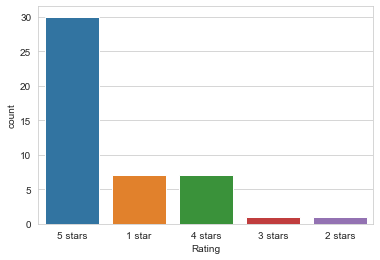

In [13]:
print(f"Number of null in label: { df['Rating'].isnull().sum() }")
print(f"Number of null in text: { df['Review'].isnull().sum() }")
sns.countplot(x='Rating', data=df);

In [14]:
X = df[['lemmatized_review', 'review_len', 'punct']]
y = df['label']
print(X.shape)
print(y.shape)

(46, 3)
(46,)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 3)
(14, 3)
(32,)
(14,)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2) # ignore terms that occur in more than 50% documents and the ones that occur in less than 2
tfidf_train = tfidf.fit_transform(X_train['lemmatized_review'])
tfidf_test = tfidf.transform(X_test['lemmatized_review'])

X_train_vect = pd.concat([X_train[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,review_len,punct,0,1,2,3,4,5,6,7,...,60,61,62,63,64,65,66,67,68,69
0,4,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,26,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,56,1.8,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,830,2.8,0.0,0.127986,0.09028,0.139824,0.000000,0.209915,0.0,0.0,...,0.000000,0.127986,0.0,0.0,0.0,0.279647,0.0,0.000000,0.0,0.0
4,175,2.3,0.0,0.248500,0.17529,0.000000,0.271485,0.000000,0.0,0.0,...,0.271485,0.000000,0.0,0.0,0.0,0.000000,0.0,0.203788,0.0,0.0


In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.92      0.92        13

    accuracy                           0.86        14
   macro avg       0.46      0.46      0.46        14
weighted avg       0.86      0.86      0.86        14



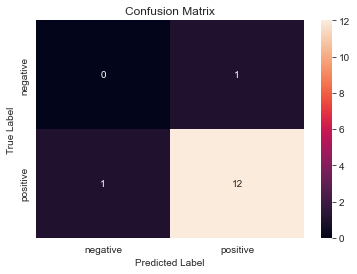

In [18]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)
naive_bayes_pred = classifier.predict(X_test_vect)

# Classification Report
print(classification_report(y_test, naive_bayes_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.93      1.00      0.96        13

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14



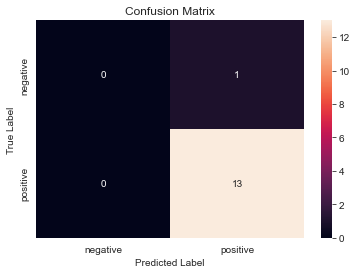

In [19]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=150)
classifier.fit(X_train_vect, y_train)
random_forest_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, random_forest_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, random_forest_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.92      0.92        13

    accuracy                           0.86        14
   macro avg       0.46      0.46      0.46        14
weighted avg       0.86      0.86      0.86        14



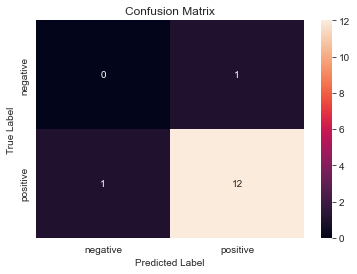

In [20]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_vect, y_train)
log_reg_pred = classifier.predict(X_test_vect)
# Classification report
print(classification_report(y_test, log_reg_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, log_reg_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.92      0.92        13

    accuracy                           0.86        14
   macro avg       0.46      0.46      0.46        14
weighted avg       0.86      0.86      0.86        14



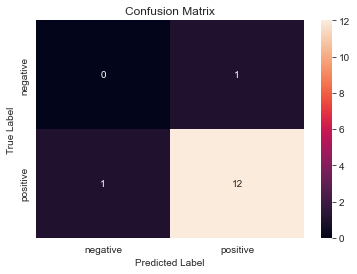

In [21]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_vect, y_train)
svm_pred = classifier.predict(X_test_vect)
# Classification report
print(classification_report(y_test, svm_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, svm_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.92      0.92        13

    accuracy                           0.86        14
   macro avg       0.46      0.46      0.46        14
weighted avg       0.86      0.86      0.86        14



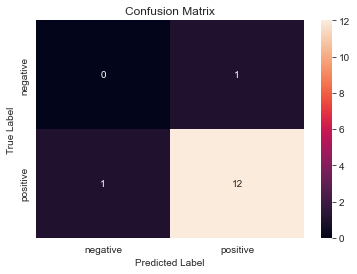

In [22]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train_vect, y_train)
knn_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, knn_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.93      1.00      0.96        13

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14



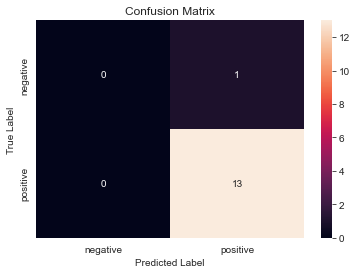

In [23]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)
classifier.fit(X_train_vect, y_train)
extra_trees_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, extra_trees_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, extra_trees_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
from sklearn.model_selection import cross_val_score

models = [
          MultinomialNB(),
          LogisticRegression(),
          RandomForestClassifier(n_estimators = 150),
          SVC(kernel = 'linear'),
          KNeighborsClassifier(n_neighbors = 5),
          ExtraTreesClassifier(n_estimators=150, random_state=50)
         ]
names = ["Naive Bayes", "Logistic Regression", "Random Forest", "SVM", "KNN", "Extra Trees"]
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "f1"]:
        print(f" {score} - {cross_val_score(model, X_train_vect, y_train, scoring=score, cv=10).mean()} ")
    print()

Naive Bayes
 accuracy - 0.75 
 precision - 0.75 
 recall - 1.0 
 f1 - 0.8514285714285714 

Logistic Regression
 accuracy - 0.75 
 precision - 0.7666666666666667 
 recall - 0.95 
 f1 - 0.8414285714285714 

Random Forest
 accuracy - 0.75 
 precision - 0.75 
 recall - 1.0 
 f1 - 0.8514285714285714 

SVM
 accuracy - 0.8416666666666666 
 precision - 0.8416666666666666 
 recall - 1.0 
 f1 - 0.9057142857142859 

KNN
 accuracy - 0.7166666666666667 
 precision - 0.7333333333333334 
 recall - 0.95 
 f1 - 0.8214285714285715 

Extra Trees
 accuracy - 0.775 
 precision - 0.775 
 recall - 1.0 
 f1 - 0.8657142857142857 



In [25]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 10)
# from sklearn.ensemble import ExtraTreesClassifier
# classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)

classifier.fit(tfidf_train, y_train)
classifier.score(tfidf_test, y_test)

0.9285714285714286

In [26]:
data = ["Bad", "Good", "I hate the service, it's really bad", "The nurse is so kind"]
vect = tfidf.transform(data).toarray()

my_pred = classifier.predict(vect)
print(my_pred)

[1 1 0 1]


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv = cv.fit_transform(df['lemmatized_review']) # Fit the Data
y_cv = df['label']

from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.3, random_state=42)

In [28]:
#Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(X_train_cv, y_train_cv)
clf.score(X_test_cv, y_test_cv)


0.8571428571428571

In [29]:
data = ["Bad", "Good", "I hate the service, it's really bad", "The nurse is so kind"]
vect = cv.transform(data).toarray()

my_prediction = clf.predict(vect)
print(my_prediction)

[1 1 1 1]
